In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

%matplotlib inline
def show(img):   
    cv2.imshow('img',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('dark_background')


## tensor 파편화를 방지하기 위한 메모리 할당

In [2]:
from tensorflow.compat.v1 import ConfigProto,InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

print(os.popen('nvidia-smi').read())

Tue Aug  4 13:53:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   34C    P0    54W / 300W |    317MiB / 32480MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   33C    P0    53W / 300W |    317MiB / 32480MiB |      9%      Default |
+-------------------------------+----------------------+----------------------+
        

## 전처리된 이미지를 불러오기 위해 Dataframe을 전처리
- 년으로 되어있는 골연령을 월로 변환후 정규화
- data가 작기 때문에 train_test_split을 8:2로 진행

In [33]:

img_size = 251
l = 391
model_weight = "tjnet_roi1.h5"

df_path = ".."
img_path = "20200728_Carpal Bone ROI_filter"
file_name = np.array(["{0:03d}_05_02.jpg".format(i+1) for i in range(l)])

df = pd.read_excel(df_path+"/BA_Total.xlsx")
imgs = np.array([cv2.imread(img_path+"/"+file_name[i]) for i in range(l)])
df['boneage'] = df.BA*12
ba_mean = df.boneage.mean()
ba_std = df.boneage.std()
df["BA_z"] = (df.boneage-ba_mean)/ba_std
df.filename = file_name
df["gender"] = df["성별"]%2

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 0)

## 사용자 함수
- multi_generator : input_data가  gender와 image 두가지이므로 generator를 통해 train_set 생성
- plot_it : 학습후 학습 진행상황을 보기위한 함수
- mae_in_months : 현재 output이 정규화 되어있는 월이므로 보기 편하도록 변환해주는 metrics

In [34]:
def multi_generator(df):
    gender_in = np.array(df.gender)
    img_in = []
    age = np.array(df.BA_z)
    
    for file_path in df.filename:
        img = cv2.imread(img_path+'/'+file_path)
        small = cv2.resize(img, (img_size,img_size),cv2.INTER_AREA)
        img_in.append(small)
        
    img_in = np.array(img_in)
        
    
    return [gender_in,img_in],age

In [35]:
# process시각화 및 손실함수

def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

from tensorflow.keras.metrics import mean_absolute_error

def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((ba_std*x_p + ba_mean), (ba_std*y_p + ba_mean)) 

## 모델 생성
- tjnet을 기반으로 모델 생성

In [36]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


In [37]:
i_input = Input(shape = (img_size,img_size,3))
#block 1
conv1 = Conv2D(32,3,activation = 'relu')(i_input)
conv2 = Conv2D(32,3,activation = 'relu')(conv1)
conv3 = Conv2D(64,3,activation = 'relu',padding='same')(conv2)
pool1 = MaxPool2D(pool_size=(2,2))(conv3)
#block 2
conv4 = Conv2D(60,1,activation = 'relu')(pool1)
conv5 = Conv2D(192,3,activation = 'relu')(conv4)
pool2 = MaxPool2D(pool_size=(2,2))(conv5)
#block 3
conv6 = Conv2D(512,3,activation = 'relu')(pool2)
pool3 = MaxPool2D(pool_size=(2,2))(conv6)
#block 4
conv7 = Conv2D(1024,3,activation = 'relu',padding='same')(pool3)
pool4 = MaxPool2D(pool_size=(2,2))(conv7)
#block 5
conv8 = Conv2D(2048,3,activation = 'relu')(pool4)
conv9 = Conv2D(2048,5,activation = 'relu')(conv8)
pool5 = AveragePooling2D(pool_size=(8,8))(conv9)
#flat
i_output = Flatten()( pool5)
# i_output = Dense(1024)(flat)

i_model = Model(inputs = i_input, outputs = i_output)


In [38]:
g_input = Input(shape = (1,))
g_output = Dense(64,activation = 'relu')(g_input)

g_model = Model(inputs = g_input,outputs = g_output)




con = concatenate([g_model.output, i_model.output])
dense1 = Dense(1024,activation='relu')(con)
# batch = BatchNormalization()(dense1)
# drop = Dropout(0.5)(dense1)
dense2 = Dense(512,activation='relu')(dense1)
# dense3 = Dense(10,activation='softmax')(dense2)
model_out = Dense(1,activation = "linear")(dense2)

model = Model([g_input,i_input],model_out)
model.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

In [39]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 251, 251, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 249, 249, 32) 896         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 247, 247, 32) 9248        conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 247, 247, 64) 18496       conv2d_28[0][0]                  
___________________________________________________________________________________________

In [40]:
train_X,train_y = multi_generator(train_df)
val_X, val_y = multi_generator(val_df)

## 모델 학습
- validation_set을 이용해 과적합되는 것을 방지

Epoch 1/100
10/10 [==============================] - 8s 821ms/step - loss: 16000320.0000 - mae_in_months: 22657.3613 - val_loss: 1.1846 - val_mae_in_months: 15.8546 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 3s 258ms/step - loss: 1.0640 - mae_in_months: 15.0704 - val_loss: 1.1934 - val_mae_in_months: 15.8646 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 11s 1s/step - loss: 0.9531 - mae_in_months: 14.1541 - val_loss: 0.8399 - val_mae_in_months: 13.1067 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 10s 1s/step - loss: 0.7257 - mae_in_months: 12.2496 - val_loss: 0.6664 - val_mae_in_months: 11.7076 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 3s 260ms/step - loss: 0.5504 - mae_in_months: 10.8071 - val_loss: 0.7651 - val_mae_in_months: 12.7825 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - 10s 1s/step - loss: 0.5579 - mae_in_months: 11.0793 - val_loss: 0.4841 - val_mae_in_months: 10.0777 -

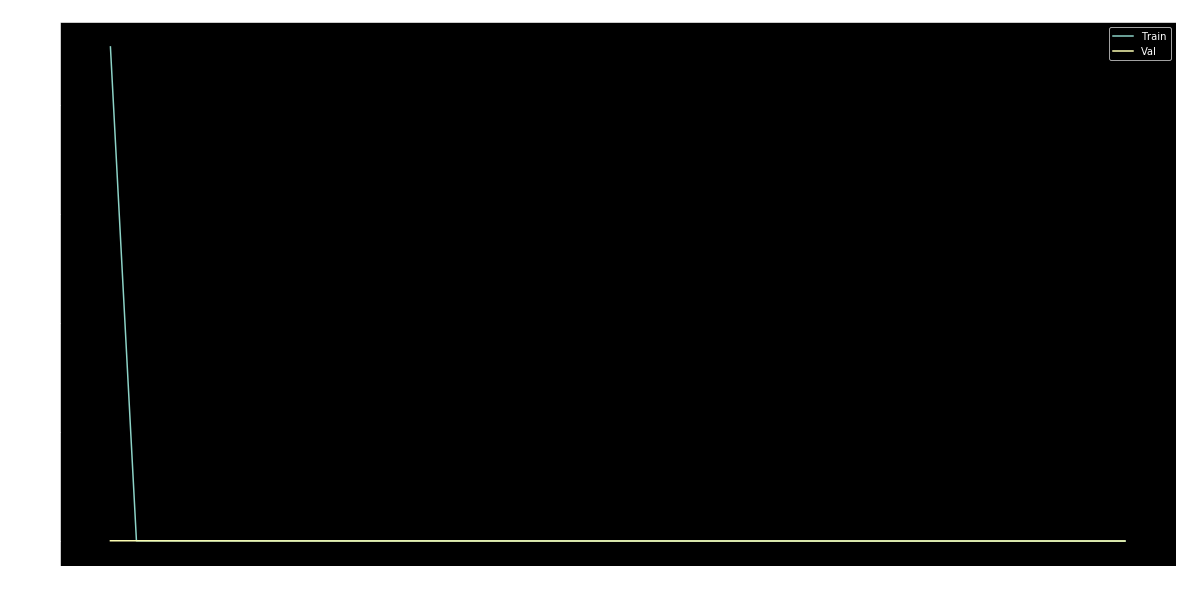

In [44]:
epochs = 100
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 10,
                              verbose=0, mode='auto')

mc = ModelCheckpoint(model_weight, monitor='val_loss', mode='min', save_best_only=True)
rLR = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=10,         # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
)

callbacks = [early_stopping,mc,rLR]


#fit model
history = model.fit(train_X,train_y,
                    validation_data = (val_X,val_y),
                    epochs = epochs,
                    callbacks= callbacks)
plot_it(history)

## Model_evlauation

In [28]:
model.load_weights(model_weight)

In [29]:
pred = model.predict(val_X)*ba_std+ba_mean
mse, mae = model.evaluate(val_X,val_y)

from sklearn.metrics import r2_score
r2 = r2_score(val_df.boneage,pred)
print(f"mae_year : {mae/12}, mse : {mse/12},r2_score : {r2}" )

3/3 [==============================] - 0s 51ms/step - loss: 0.1216 - mae_in_months: 5.0177
mae_year : 0.4181406497955322, mse : 0.010136021922032038,r2_score : 0.8658634600763864


In [42]:
from sklearn.metrics import mean_absolute_error
v = val_y*ba_std+ba_mean
mean_absolute_error(np.round(pred),v)/12,mean_absolute_error(pred,v)/12

(0.4012658227848102, 0.407534607754478)

In [34]:
result_df = pd.read_csv("result.csv")
result_df.loc[len(result_df)]=(model_weight,mae/12,mse/12,r2,True,False)
result_df.to_csv("result.csv",index=False)
result_df

,model,mae,mse,r2_score,roi,class
0,xception++,1.540548,17.096090,-180.695600,False,False
1,vgg-ba,1.160614,0.073136,-0.303073,False,False
2,vgg-ba,0.670392,0.025254,-0.570250,True,False
3,xception++,0.557815,0.016407,-0.361841,True,False
4,pre xception++,0.639215,0.022091,-1.055396,True,False
5,xception+gender,0.551765,0.017635,0.766628,True,False
6,pre-xception+gender,0.600951,0.020432,0.729614,True,False
7,tjnet-gender2,0.407535,0.009509,0.874158,True,False
